In [140]:
from scapy.all import *
import pandas as pd
import numpy as np
import binascii
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [170]:
# pcap to dataframe

pcap = rdpcap("../pcaps/webinar_pcap_compressed_3.pcap")

ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    field_values = []
    for field in ip_fields:
        if field == 'options':
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# replace proto values with strings 'tcp' or 'udp'

#df['proto'] = df['proto'].replace([6],'tcp')
#df['proto'] = df['proto'].replace([17],'udp')

df = df.reset_index()
df = df.drop(columns="index")

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
45,4,5,0,113,36850,DF,0,64,6,6705,...,8,0,PA,502,37063,0,3,61,b'\xc0\xa8\x07\x8c\x00\x04\x00\x00\x001\xb1\x0...,b'c0a8078c000400000031b10b3f8c15f921cd85fc32f9...
46,4,5,0,52,47369,DF,0,64,6,61782,...,8,0,A,509,20477,0,3,0,b'',b''
47,4,5,0,64,1,,0,64,17,59976,...,None,None,None,None,41184,None,None,36,b'\xc0\xa8\x07\x87\x00\x03\x00\x11\x00\x05\x12...,b'c0a807870003001100051234112190001034312e3430...
48,4,5,0,52,36851,DF,0,64,6,6765,...,8,0,FA,502,37002,0,3,0,b'',b''
49,4,5,0,52,47370,DF,0,64,6,61781,...,8,0,A,509,18031,0,3,0,b'',b''


proto
6     43
17     7
Name: src, dtype: int64


<AxesSubplot:title={'center':'Protocol Distribution'}, ylabel='proto'>

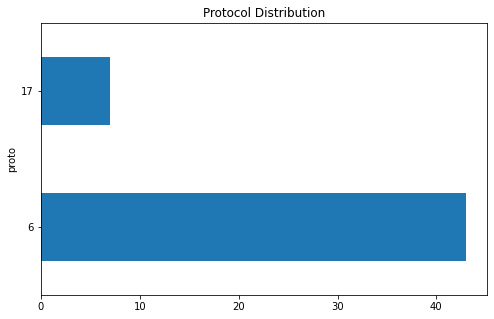

In [171]:
protocol_stats = df.groupby("proto")['src'].count()
print(protocol_stats)
protocol_stats.plot(kind='barh',title="Protocol Distribution",figsize=(8,5))


<AxesSubplot:title={'center':'Addresses Sending Payloads'}, ylabel='src'>

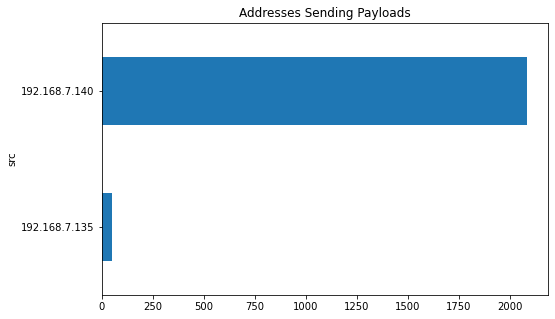

In [172]:
# Graph - Group by Source Address and Payload Sum

source_addresses = df.groupby("src")['payload'].sum()
source_addresses.plot(kind='barh',title="Addresses Sending Payloads",figsize=(8,5))

<AxesSubplot:title={'center':'Addresses Receiving Payloads'}, ylabel='dst'>

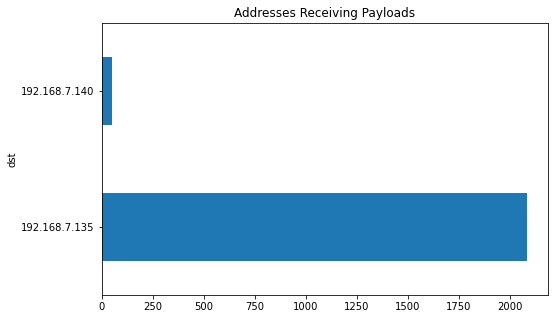

In [173]:
# Graph - Group by Dest Address and Payload Sum

dst_addresses = df.groupby("dst")['payload'].sum()
dst_addresses.plot(kind='barh',title="Addresses Receiving Payloads",figsize=(8,5))

<AxesSubplot:title={'center':'Destination Ports (Bytes Received)'}, ylabel='dport'>

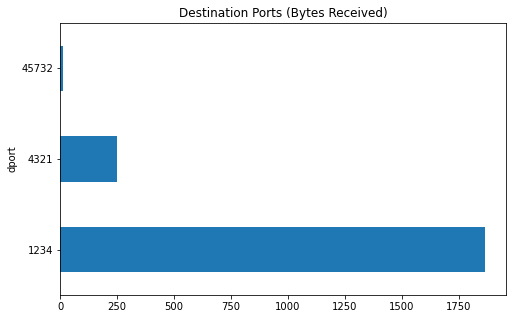

In [174]:
# Graph - Group by Destination Port and Payload Sum

destination_ports = df.groupby("dport")['payload'].sum()
destination_ports.plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))

<AxesSubplot:title={'center':'Destination Ports by Protocol (Bytes Received)'}, ylabel='dport,proto'>

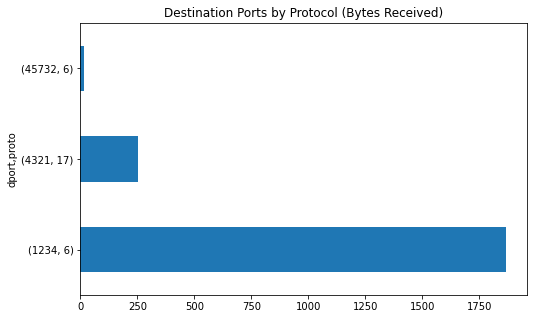

In [175]:
# Graph - Group by Destination Port, Protocol and Payload Sum

destination_payloads_proto = df.groupby(["dport","proto"])['payload'].sum()
destination_payloads_proto.plot(kind='barh',title="Destination Ports by Protocol (Bytes Received)",figsize=(8,5))

In [193]:
# Timeline of packets - tcp & udp 

# Downselect all udp and tcp packets

udp_packets=df[df['proto']=='udp']
tcp_packets=df[df['proto']=='tcp']

# Adding human-readable timestamp column

def return_timestamp(x):
    return datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S.%f')

df['timestamp'] = df['time'].apply(lambda x: (return_timestamp(x)))

npackets=list(range(0,len(df)))

# df.set_index('time')



([<matplotlib.axis.YTick at 0x7fb0aa923cd0>,
 [Text(0, 6, 'tcp'), Text(0, 17, 'udp')])

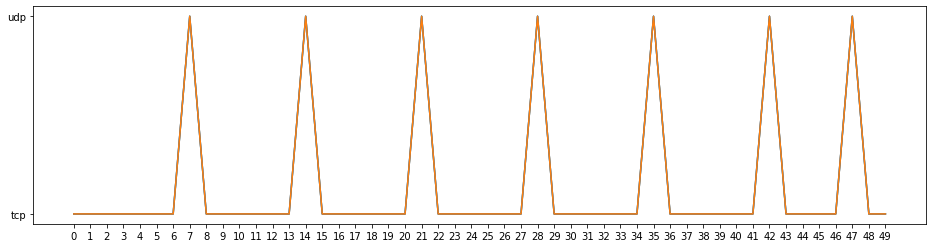

In [239]:
df['proto'].plot(figsize=(16,4))
df['proto'].plot(subplots=True, figsize=(16,4))
df['proto'].plot(y=["proto"], figsize=(16,4))
plt.xticks(df.index)
plt.yticks([6,17],['tcp','udp'])

